In [1]:
import os

import cv2 as cv
import pandas as pd
import torch
import torchvision.transforms as transforms
from PIL import Image
from catalyst.dl.utils import UtilsFactory
from tqdm import tqdm

import argparse

from models.utils import get_model

In [2]:
test_df_path = '../data/test_df.csv'
dataset_path = '../data'
network = 'linknet'
model_weights_path = '../data/best.pth'

In [43]:
def get_filename(info_record):
    return '{}_{}_{}'.format(
        info_record['name'],
        info_record['channel'],
        info_record['position'])


def get_full_filename(info_record, type_col='mask_type'):
    return '{}.{}'.format(
        get_filename(info_record),
        info_record[type_col])


def get_image(info_record):
    image_path = os.path.join(
        info_record['image_path'],
        get_full_filename(info_record, 'image_type'))
    
    mask_path = os.path.join(
        info_record['mask_path'],
        get_full_filename(info_record))

    img = Image.open(image_path)
    mask = Image.open(mask_path)

    img_tensor = transforms.ToTensor()(img)
    mask_tensor = transforms.ToTensor()(mask)

    return {'features': img_tensor, 'targets': mask_tensor}


def load_model(network, model_weights_path):
    model = get_model(network)
    checkpoint = torch.load(model_weights_path, map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model.eval()


def predict(model, image_tensor, input_shape=(1, 3, 224, 224)):
    prediction = model(image_tensor.view(*input_shape))
    return torch \
        .sigmoid(prediction.view(*input_shape[2:])) \
        .detach().numpy()


def get_predictions(network, model_weights_path, test_df_path):
    model = load_model(network, model_weights_path)

    test_df = pd.read_csv(test_df_path)

    predictions = {}
    for _, info_record in tqdm(test_df.iterrows()):
        data = get_image(info_record)
        
        predictions[get_filename(info_record)] = predict(
            model, data['features'])
        
    return predictions


def save_predictions(predictions, save_path):
    predictions_path = os.path.join(save_path, 'predictions')
    
    if not os.path.exists(predictions_path):
        os.mkdir(predictions_path)
        print('Pediction directory created.')
        
    for filename, image in predictions.items():
        cv.imwrite(
            os.path.join(
                predictions_path,
                filename + '.png'),
            image * 255)
    
    print('Predictions saved.')

In [44]:
predictions = get_predictions(network, model_weights_path, test_df_path)

49it [00:06,  7.57it/s]


In [45]:
save_predictions(predictions, dataset_path)

Predictions saved.


In [46]:
y = []
y_hat = []
test_df = pd.read_csv(test_df_path)
for _, info_record in tqdm(test_df.iterrows()):
    y.append(get_image(info_record)['targets'].numpy()[0])
    y_hat.append(predictions[get_filename(info_record)])

49it [00:00, 547.24it/s]


In [47]:
import matplotlib.pyplot as plt

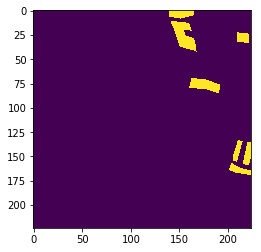

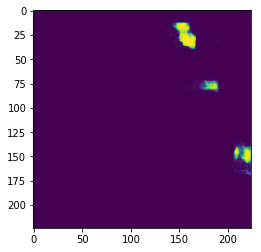

__________________________


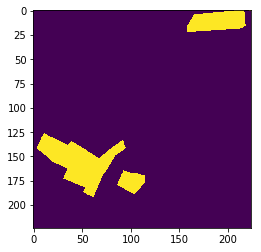

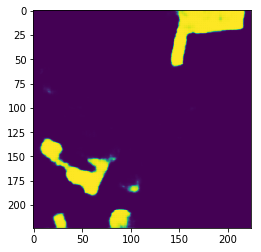

__________________________


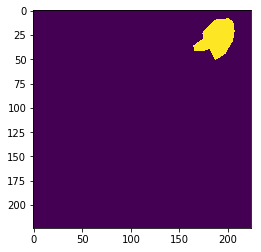

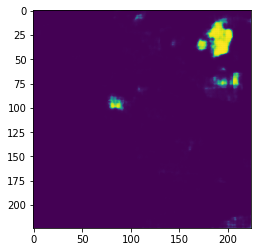

__________________________


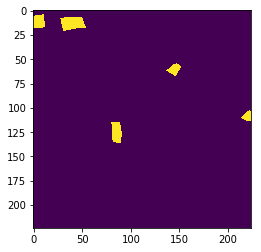

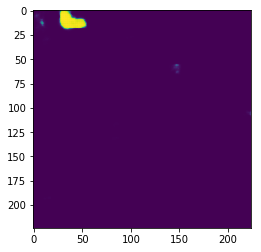

__________________________


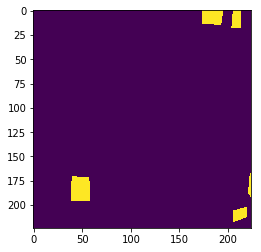

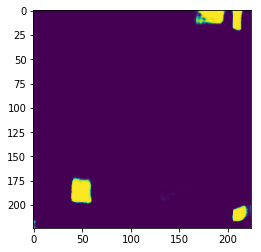

__________________________


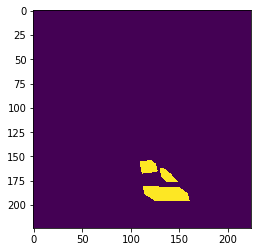

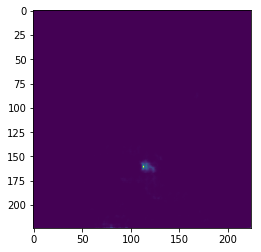

__________________________


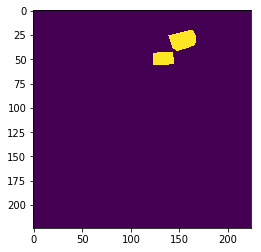

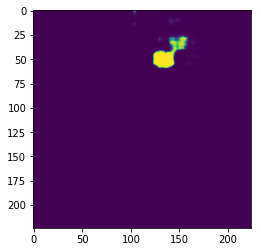

__________________________


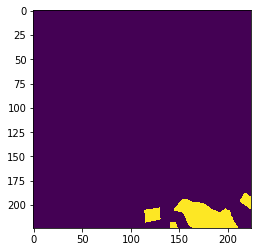

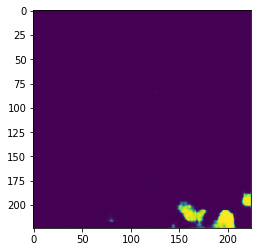

__________________________


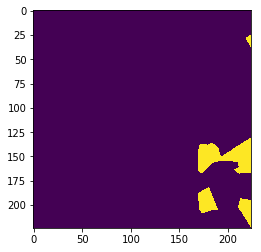

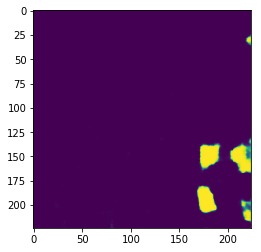

__________________________


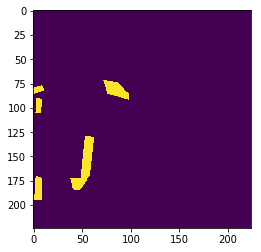

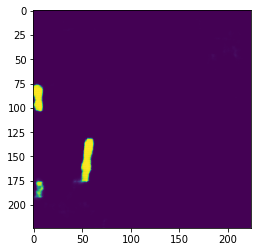

__________________________


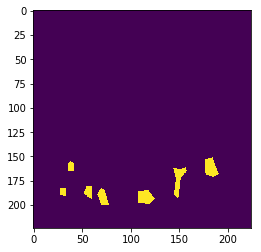

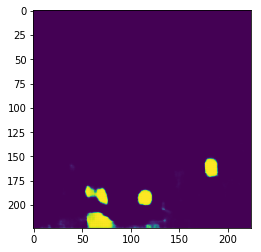

__________________________


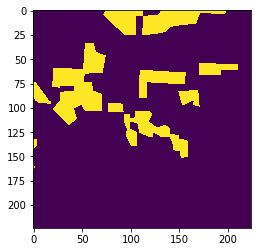

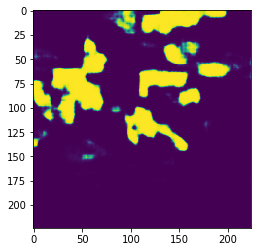

__________________________


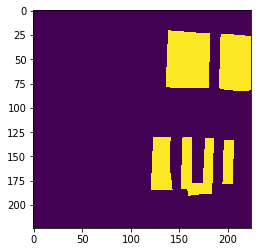

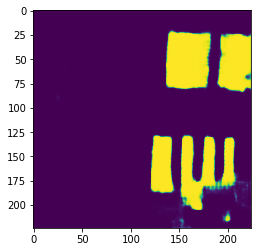

__________________________


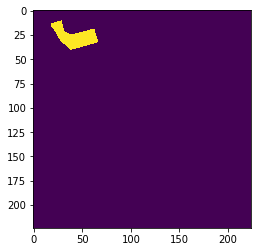

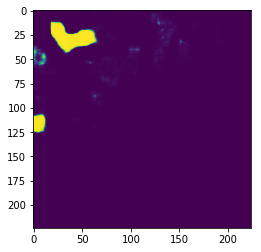

__________________________


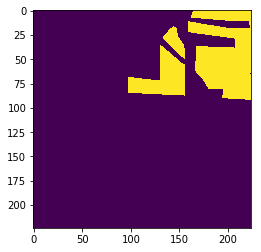

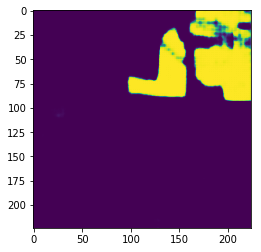

__________________________


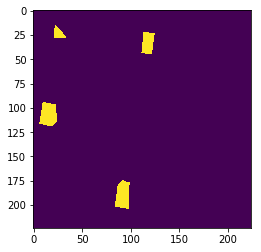

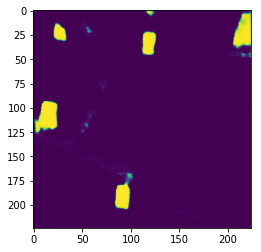

__________________________


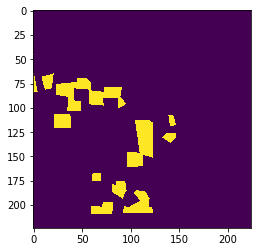

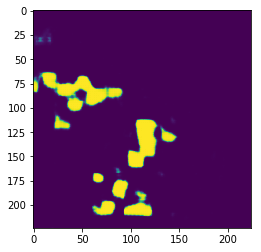

__________________________


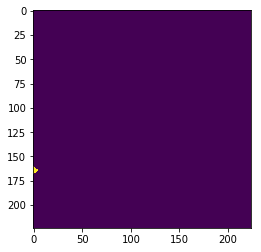

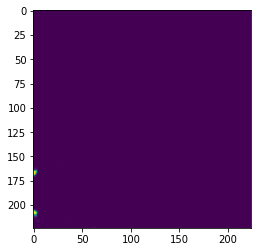

__________________________


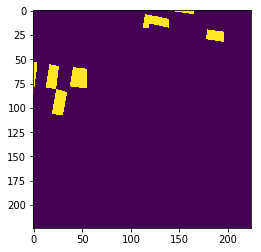

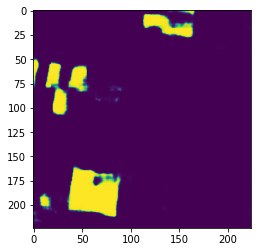

__________________________


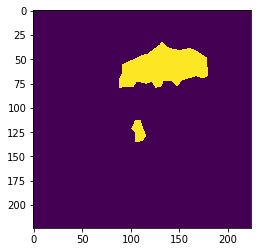

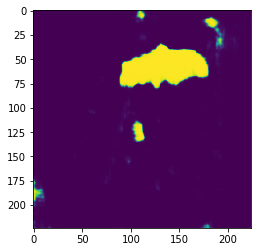

__________________________


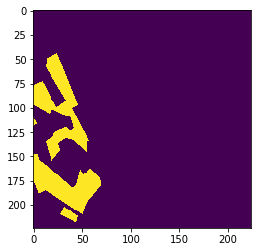

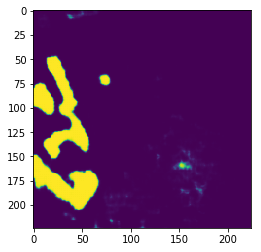

__________________________


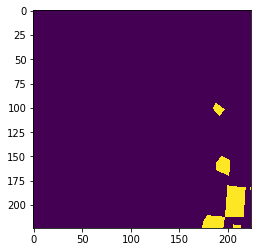

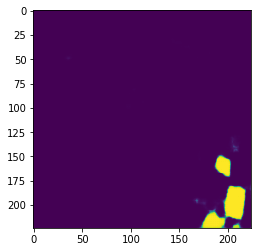

__________________________


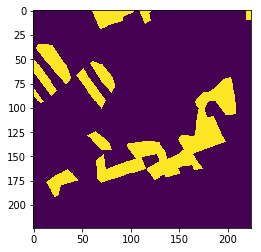

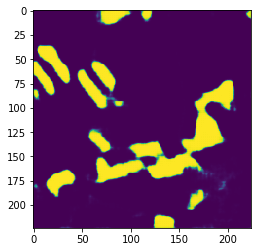

__________________________


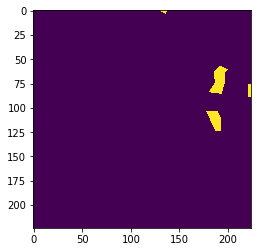

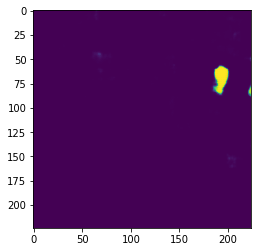

__________________________


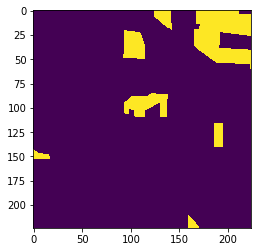

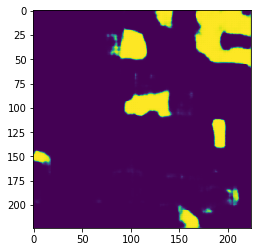

__________________________


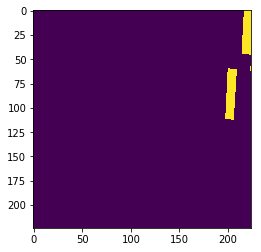

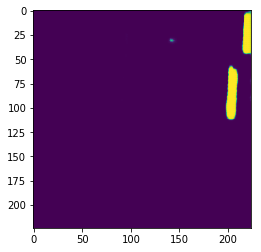

__________________________


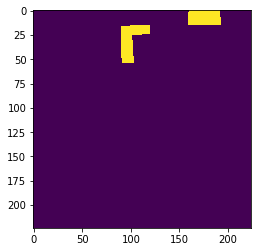

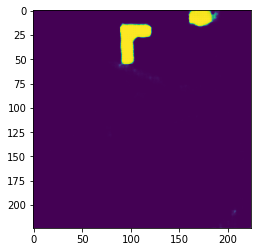

__________________________


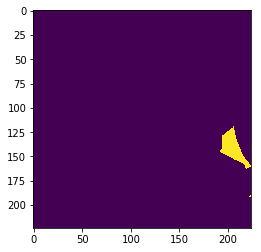

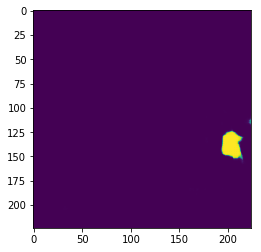

__________________________


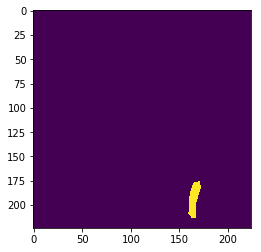

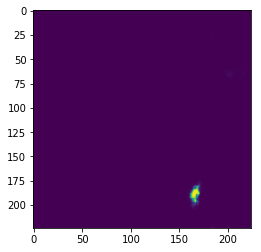

__________________________


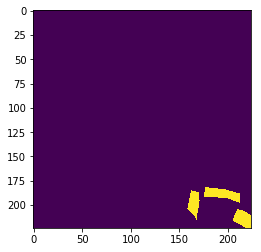

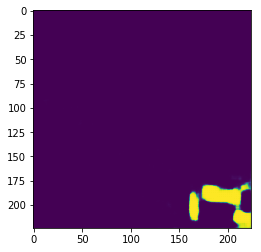

__________________________


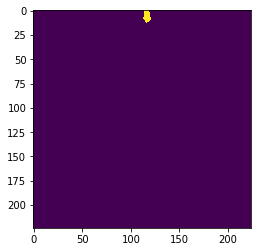

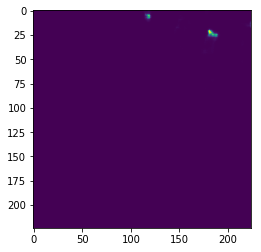

__________________________


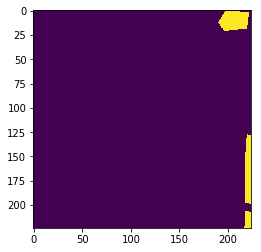

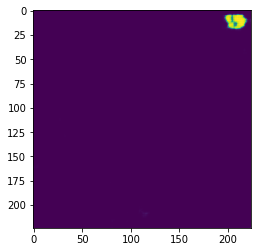

__________________________


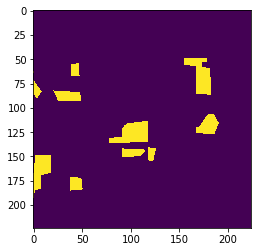

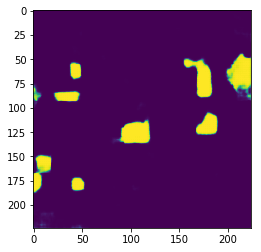

__________________________


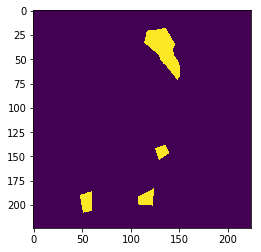

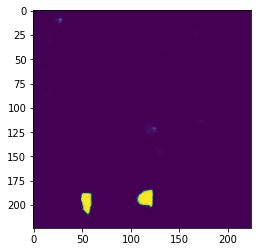

__________________________


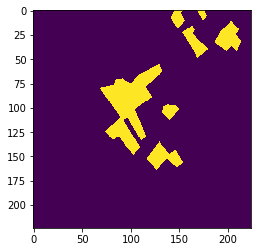

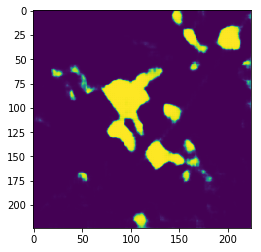

__________________________


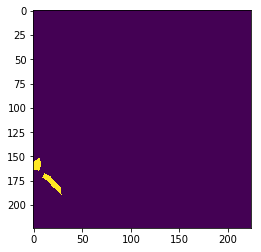

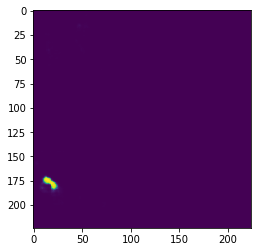

__________________________


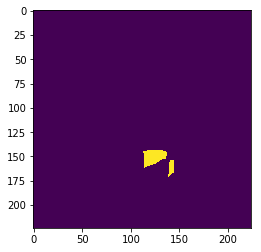

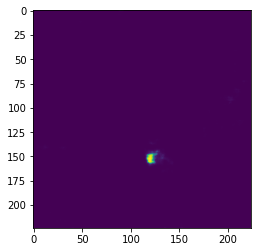

__________________________


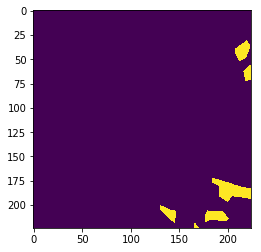

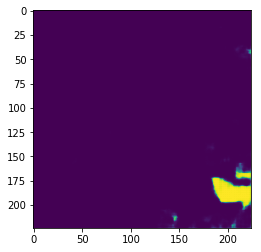

__________________________


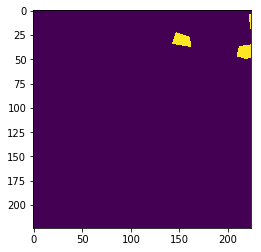

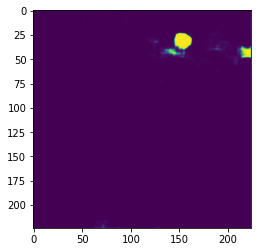

__________________________


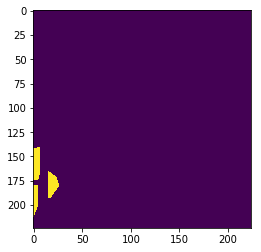

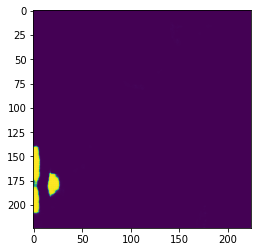

__________________________


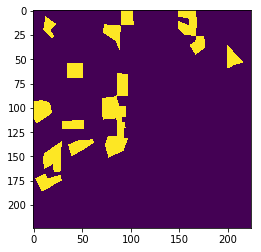

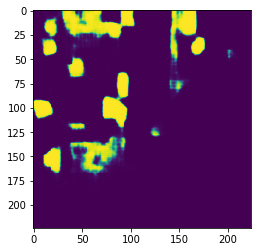

__________________________


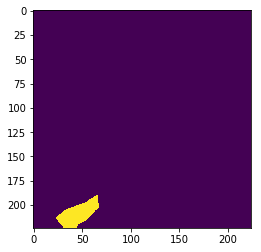

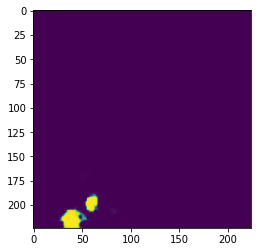

__________________________


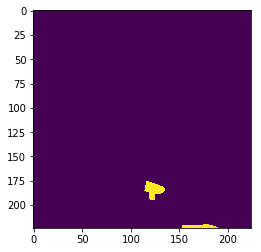

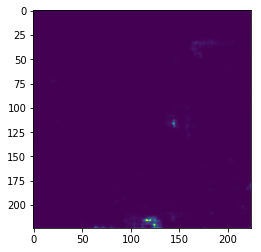

__________________________


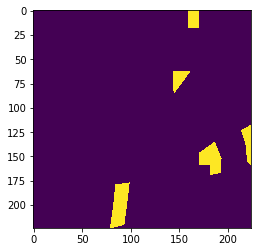

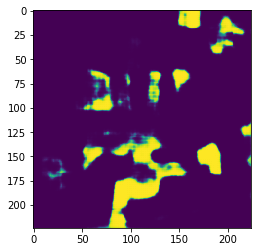

__________________________


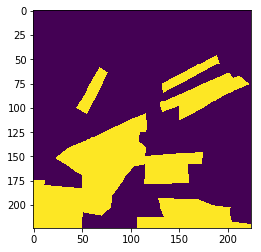

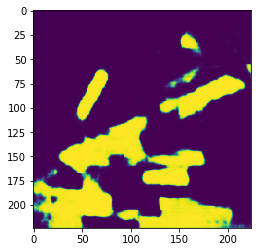

__________________________


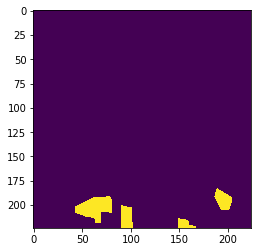

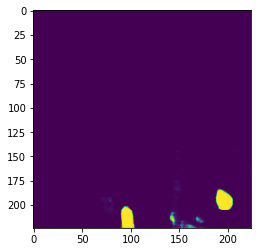

__________________________


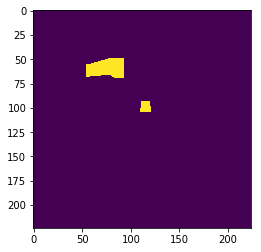

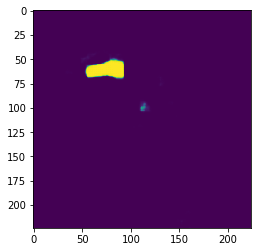

__________________________


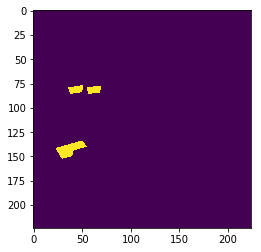

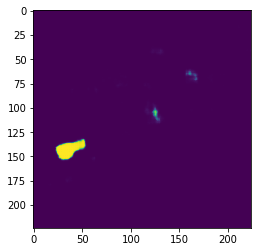

__________________________


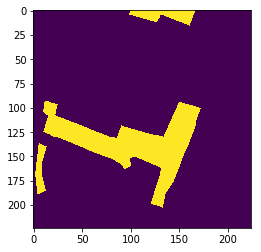

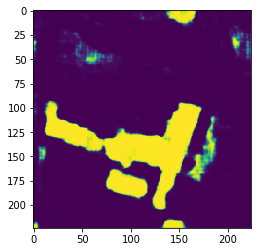

__________________________


In [48]:
for true, pred in zip(y, y_hat):
    plt.imshow(true)
    plt.show()
    plt.imshow(pred)
    plt.show()
    print('__________________________')